# Protein Embedding Clusters Visualization

This notebook visualizes clusters in protein embeddings using dimensionality reduction techniques (UMAP and t-SNE).

Author: Hamed Heydari @ Vevo  
Date: April, 2025

In [27]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from umap import UMAP
import time
import random

# To create color map for the gene families
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set better figure defaults
plt.rcParams['figure.figsize'] = (12, 10)
plt.style.use('ggplot')

plt.rcParams.update({
    'font.family': 'sans-serif',  # Using a generic sans-serif font that's available
    'font.sans-serif': ['DejaVu Sans', 'Helvetica', 'Liberation Sans', 'sans-serif'],
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.edgecolor': 'black',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.major.size': 5,
    'ytick.major.size': 5
})

## Load Protein Embeddings

We'll first load the embeddings from the HDF5 file and sample a subset for visualization.

In [28]:
# Path to the embeddings file
embedding_file = "../output/protein_embeddings_esmc_600m.h5"

# Load the embeddings
with h5py.File(embedding_file, "r") as f:
    # Get file metadata
    num_proteins = f.attrs.get('num_proteins', 0)
    model_name = f.attrs.get('embedding_model', 'unknown')
    embedding_dim = f.attrs.get('embedding_dimension', 0)
    
    print(f"Model: {model_name}")
    print(f"Total proteins: {num_proteins}")
    print(f"Embedding dimension: {embedding_dim}")
    
    # Load the full datasets
    all_embeddings = f["embeddings"][:]
    all_uniprot_ids = [id.decode('utf-8') for id in f["uniprot_ids"][:]]
    all_gene_names = [name.decode('utf-8') if name else "" for name in f["gene_names"][:]]
    
print(f"Loaded {len(all_embeddings)} embeddings with dimension {all_embeddings.shape[1]}")

Model: esmc_600m
Total proteins: 19329
Embedding dimension: 1152
Loaded 19329 embeddings with dimension 1152


## Sample Embeddings

For computational efficiency, we'll sample a subset of embeddings for visualization.

In [29]:
# Set sample size for visualization
SAMPLE_SIZE = len(all_embeddings) # This means full data. For quick checks, reduce it to 5K or less.

# Set random seed for reproducibility
random.seed(42)

# Sample without replacement if possible
if SAMPLE_SIZE <= len(all_embeddings):
    indices = random.sample(range(len(all_embeddings)), SAMPLE_SIZE)
else:
    indices = list(range(len(all_embeddings)))
    print(f"Warning: Requested sample size {SAMPLE_SIZE} exceeds available data {len(all_embeddings)}")
    SAMPLE_SIZE = len(all_embeddings)

# Extract the sampled data
embeddings = all_embeddings[indices]
uniprot_ids = [all_uniprot_ids[i] for i in indices]
gene_names = [all_gene_names[i] for i in indices]

print(f"Sampled {SAMPLE_SIZE} proteins for visualization")

scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

Sampled 19329 proteins for visualization


## UMAP & tSNE Visualization

In [30]:
print("Running UMAP...")
start_time = time.time()

# Configure UMAP
umap_reducer = UMAP(
    n_components=2,
    n_neighbors=15,  # Controls local versus global structure preservation (higher = more global)
    min_dist=1.0,    # Controls how tightly points are packed (lower = tighter clusters)
    metric='euclidean',
    verbose=True
)

# Fit and transform the embeddings
umap_result = umap_reducer.fit_transform(embeddings)

umap_df = pd.DataFrame({
    'UMAP1': umap_result[:, 0],
    'UMAP2': umap_result[:, 1],
    'UniProt': uniprot_ids,
    'Gene': gene_names
})

print(f"UMAP completed in {time.time() - start_time:.2f} seconds")

Running UMAP...
UMAP(min_dist=1.0, verbose=True)
Tue Apr  8 01:10:21 2025 Construct fuzzy simplicial set
Tue Apr  8 01:10:21 2025 Finding Nearest Neighbors
Tue Apr  8 01:10:21 2025 Building RP forest with 12 trees


/vevo/micromamba/envs/esm-c/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Tue Apr  8 01:10:21 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Tue Apr  8 01:10:22 2025 Finished Nearest Neighbor Search
Tue Apr  8 01:10:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Apr  8 01:10:24 2025 Finished embedding
UMAP completed in 2.93 seconds


## Analyze Specific Gene Groups

Let's check if genes with similar functions cluster together in the embedding space.

In [31]:
# Define some gene families for highlighting
gene_families = {
    'Hemoglobin': [g for g in gene_names if g.startswith('HB')],
    'Kinases': [g for g in gene_names if g.endswith('K') or 'KIN' in g or 'CDK' in g],
    'Histones': [g for g in gene_names if g.startswith('HIST')],
    'Collagen': [g for g in gene_names if g.startswith('COL')],
    'Zinc Finger': [g for g in gene_names if g.startswith('ZNF')]
}

# Print counts of genes found in each family
print("Genes found in defined families:")
for family, genes in gene_families.items():
    print(f"  {family}: {len(genes)} genes")
    if len(genes) > 0:
        print(f"    Examples: {', '.join(genes[:5])}")
        if len(genes) > 5:
            print(f"    ...and {len(genes) - 5} more")

Genes found in defined families:
  Hemoglobin: 12 genes
    Examples: HBA1; HBA2, HBS1L, HBEGF, HBM, HBB
    ...and 7 more
  Kinases: 182 genes
    Examples: CDKL4, AGK, CDK16, POGK, CDK19
    ...and 177 more
  Histones: 0 genes
  Collagen: 50 genes
    Examples: COL4A2, COLGALT1, COLGALT2, COL8A2, COL16A1
    ...and 45 more
  Zinc Finger: 508 genes
    Examples: ZNF706, ZNF804A, ZNF615, ZNF211, ZNF892
    ...and 503 more


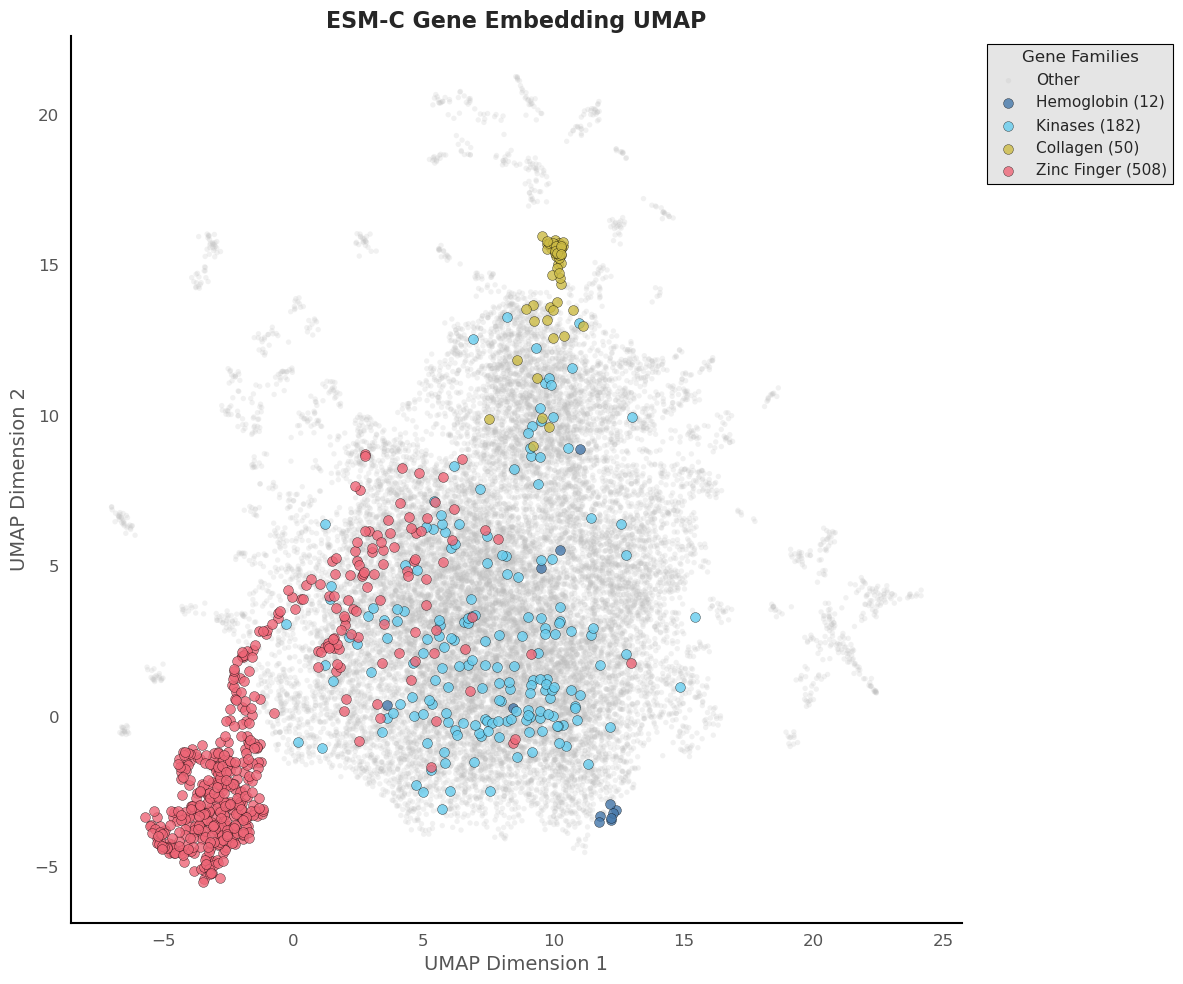

In [33]:
# Define color palette
colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', 
          '#AA3377', '#BBBBBB', '#004488', '#DDAA33']

# Add more colors if needed
if len(gene_families) > 9:
    colors.extend(plt.cm.tab20(range(len(gene_families) - 9)))

# Assign colors to families
family_colors = {family: colors[i % len(colors)] for i, family in enumerate(gene_families)}
family_colors['Other'] = '#BBBBBB'  # Gray for Other category

# Map genes to their families
gene_to_family = {}
for family, genes in gene_families.items():
    for gene in genes:
        gene_to_family[gene] = family

# Get family for each gene in visualization
point_families = [gene_to_family.get(gene, 'Other') for gene in gene_names]

# Create plot
fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
ax.set_facecolor('white')

# Plot background points first
other_indices = [i for i, family in enumerate(point_families) if family == 'Other']
if other_indices:
    ax.scatter(
        umap_df['UMAP1'].iloc[other_indices],
        umap_df['UMAP2'].iloc[other_indices],
        s=15, alpha=0.2, color=family_colors['Other'],
        label='Other', edgecolor='none'
    )

# Plot each gene family
for family in gene_families:
    family_indices = [i for i, f in enumerate(point_families) if f == family]
    if family_indices:
        ax.scatter(
            umap_df['UMAP1'].iloc[family_indices],
            umap_df['UMAP2'].iloc[family_indices],
            s=50, alpha=0.8, color=family_colors[family],
            label=f'{family} ({len(family_indices)})',
            edgecolor='k', linewidth=0.3
        )

# Style the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_title('ESM-C Gene Embedding UMAP', fontsize=16, fontweight='bold')
ax.set_xlabel('UMAP Dimension 1', fontsize=14)
ax.set_ylabel('UMAP Dimension 2', fontsize=14)

# Add legend
legend = ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    frameon=True, fancybox=False, framealpha=1,
    edgecolor='black', fontsize=11,
    title='Gene Families', title_fontsize=12
)
legend.get_frame().set_linewidth(0.8)

plt.tight_layout()
plt.show()

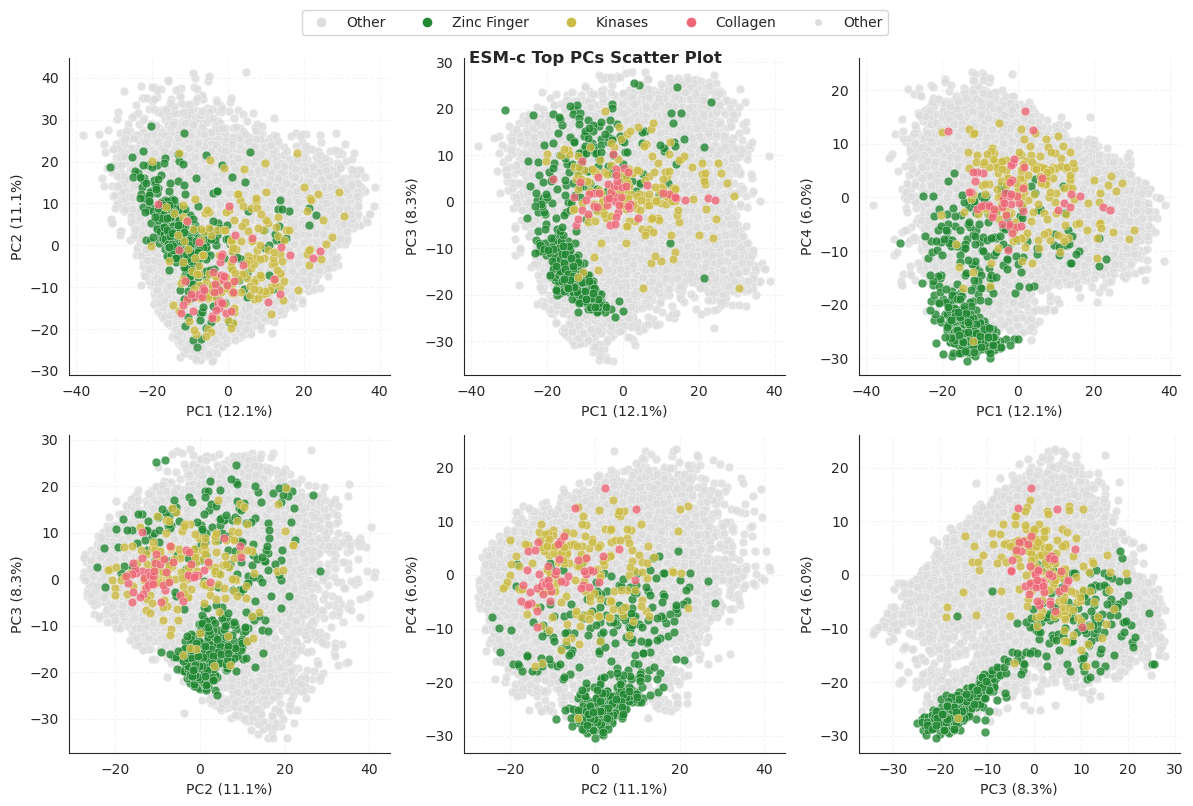

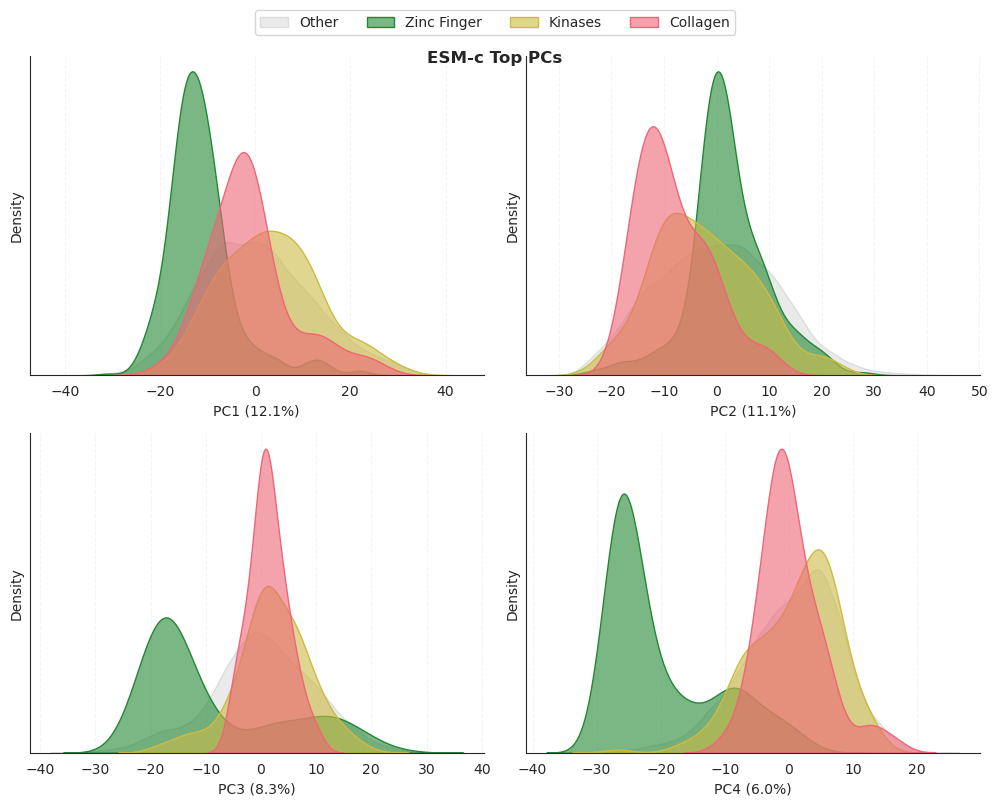

In [34]:
plt.style.use('default')
sns.set_style("white")

# Run PCA and prepare data
pca = PCA(n_components=4)
pca_result = pca.fit_transform(embeddings)
pc_vars = [f'PC{i+1}' for i in range(4)]

# Create DataFrame with family information
pca_df = pd.DataFrame(pca_result, columns=pc_vars)
pca_df['Family'] = [gene_to_family.get(gene, 'Other') for gene in gene_names]

# Get top 4 families and mark for highlighting
top_families = pd.Series(pca_df['Family']).value_counts().head(4).index.tolist()
pca_df['HighlightFamily'] = pca_df['Family'].apply(
    lambda x: x if x in top_families else 'Other'
)

# Color palette for visualization
colors = {
    top_families[0]: '#4477AA', 
    top_families[1]: '#228833', 
    top_families[2]: '#CCBB44', 
    top_families[3]: '#EE6677', 
    'Other': '#DDDDDD'
}

# Create pairwise scatter plots
fig1, axes1 = plt.subplots(2, 3, figsize=(12, 8), facecolor='white')
axes1 = axes1.flatten()
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

for i, (pc_i, pc_j) in enumerate(pairs):
    ax = axes1[i]
    ax.set_facecolor('white')
    
    # Plot background points
    other_mask = pca_df['HighlightFamily'] == 'Other'
    ax.scatter(
        pca_df[pc_vars[pc_i]][other_mask], 
        pca_df[pc_vars[pc_j]][other_mask],
        s=10, alpha=0.15, color=colors['Other']
    )
    
    # Plot family points
    for family in top_families:
        family_mask = pca_df['HighlightFamily'] == family
        ax.scatter(
            pca_df[pc_vars[pc_i]][family_mask], 
            pca_df[pc_vars[pc_j]][family_mask],
            s=40, alpha=0.8, color=colors[family], 
            edgecolor='white', linewidth=0.3
        )
    
    # Style the subplot
    var_explained = pca.explained_variance_ratio_
    ax.set_xlabel(f"{pc_vars[pc_i]} ({var_explained[pc_i]*100:.1f}%)")
    ax.set_ylabel(f"{pc_vars[pc_j]} ({var_explained[pc_j]*100:.1f}%)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.2)

# Add legend to scatter plot figure
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[f], 
               markersize=8, label=f) 
    for f in top_families
]
handles.append(
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['Other'], 
               markersize=6, label='Other')
)
fig1.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.01))
fig1.suptitle('ESM-c Top PCs Scatter Plot', y=0.95, fontweight='bold')
fig1.tight_layout()

# Create KDE plots for each PC
fig2, axes2 = plt.subplots(2, 2, figsize=(10, 8), facecolor='white')
axes2 = axes2.flatten()

for i in range(4):
    ax = axes2[i]
    ax.set_facecolor('white')
    
    for family in top_families:
        family_data = pca_df[pc_vars[i]][pca_df['HighlightFamily'] == family]
        sns.kdeplot(
            x=family_data, ax=ax, color=colors[family], 
            fill=True, alpha=0.6, 
            label=family if i == 0 else None
        )
    
    ax.set_xlabel(f"{pc_vars[i]} ({var_explained[i]*100:.1f}%)")
    ax.set_ylabel('Density')
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.2)

# Handle legend for KDE plots
if axes2[0].get_legend() is not None:
    axes2[0].get_legend().remove()
fig2.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.01))
fig2.suptitle('ESM-c Top PCs', y=0.95, fontweight='bold')
fig2.tight_layout()

plt.show()

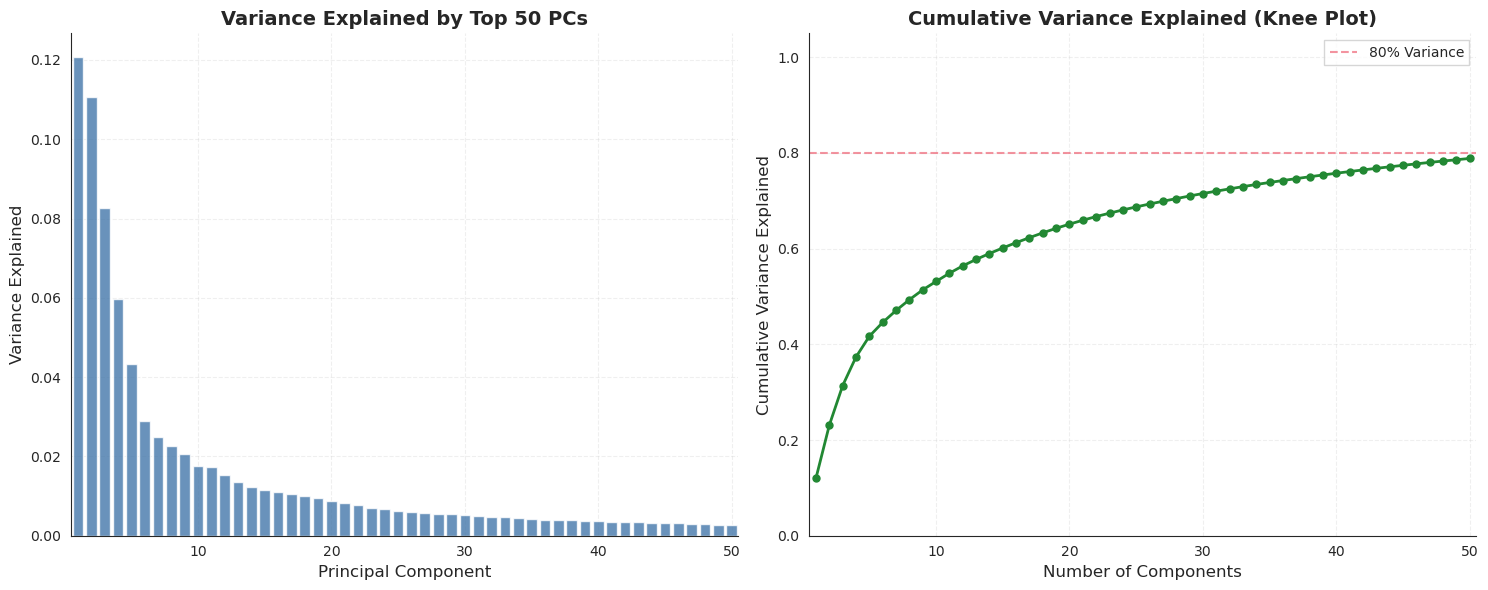

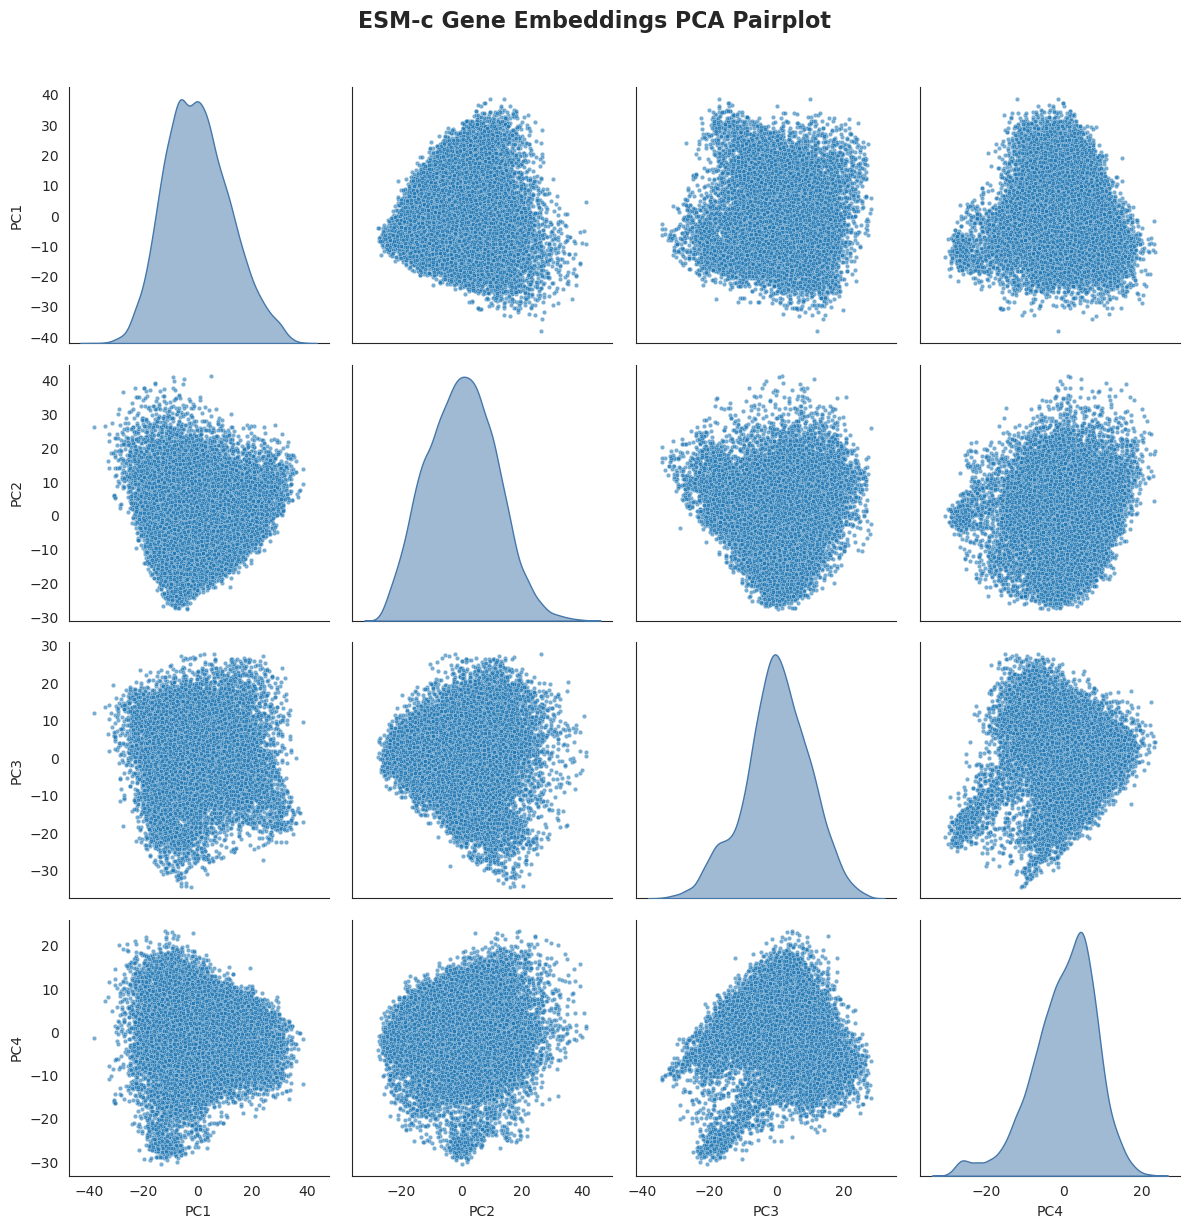

In [41]:
# Recalculate PCA with 50 components
pca = PCA(n_components=50)
pca_result = pca.fit_transform(embeddings)
var_explained = pca.explained_variance_ratio_

# Create figure for the first two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Variance explained bar plot
ax1.bar(range(1, 51), var_explained, alpha=0.8, color='#4477AA')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Variance Explained', fontsize=12)
ax1.set_title('Variance Explained by Top 50 PCs', fontsize=14, fontweight='bold')
ax1.set_xlim(0.5, 50.5)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate cumulative variance
cumulative_variance = np.cumsum(var_explained)

# 2. Knee plot (cumulative variance explained)
ax2.plot(range(1, 51), cumulative_variance, '-o', markersize=5, 
        linewidth=2, color='#228833')
ax2.axhline(y=0.8, color='#EE6677', linestyle='--', alpha=0.7, 
           label='80% Variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained', fontsize=12)
ax2.set_title('Cumulative Variance Explained (Knee Plot)', fontsize=14, fontweight='bold')
ax2.set_xlim(0.5, 50.5)
ax2.set_ylim(0, 1.05)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(frameon=True, fancybox=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


plt.tight_layout()
plt.show()

# 3. Create a DataFrame for the top 5 PCs
pc_df = pd.DataFrame(
    data=pca_result[:, :5], 
    columns=[f'PC{i+1}' for i in range(5)]
)

# Add family column for color coding
pc_df['Family'] = [gene_to_family.get(gene, 'Other') for gene in gene_names]

# Get the top 4 most common families for color coding
top_families = pd.Series(pc_df['Family']).value_counts().head(4).index.tolist()
pc_df['TopFamily'] = pc_df['Family'].apply(lambda x: x if x in top_families else 'Other')

# Create color mapping
palette = {
    top_families[0]: '#4477AA',
    top_families[1]: '#228833',
    top_families[2]: '#CCBB44',
    top_families[3]: '#EE6677',
    'Other': '#DDDDDD'
}

# Create the pair plot
g = sns.pairplot(
    pca_df, 
    diag_kind="kde",
    plot_kws={"alpha": 0.6, "s": 10},
    diag_kws={"alpha": 0.5, "color": "#4477AA"},
    height=3
)

g.fig.suptitle('ESM-c Gene Embeddings PCA Pairplot', 
              fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()